In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from datetime import datetime
from os import path
import os
import sklearn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
from optuna import Trial


# PAS NECESSAIRE
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Créez une instance de modèle
class EmotionRecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(EmotionRecognitionModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer(x)
        return x
    
def fit(model, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=32, lr=0.01, verbose=True):
    train_dataset = TensorDataset(X_train.reshape(-1, model.input_dim).clone().detach(), y_train.clone().detach())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    if X_val is not None and y_val is not None:
        val_dataset = TensorDataset(X_val.reshape(-1, model.input_dim).clone().detach(), y_val.clone().detach())
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in tqdm(range(epochs), desc="Traitement en cours", bar_format="{l_bar}{bar:10}{r_bar}"):
        # Training loop
        train_loss = 0.0
        train_acc = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch.float())
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy_score(y_batch, y_pred.argmax(dim=1))
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        # Validation loop
        if X_val is not None and y_val is not None:
            val_loss = 0.0
            val_acc = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_pred = model(X_batch.float())
                    loss = criterion(y_pred, y_batch)
                    val_loss += loss.item()
                    val_acc += accuracy_score(y_batch, y_pred.argmax(dim=1))
                
            val_loss /= len(val_loader)
            val_acc /= len(val_loader)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
        
        if verbose:
            if X_val is not None and y_val is not None:
                print(f'Epoch {epoch+1}/{epochs}, "\n", Train Loss: {train_loss:.4f}, Train Accuracy : {train_acc:.4f}, "\n" , Val Loss: {val_loss:.4f}, Val Accuracy : {val_acc:.4f}')
            else:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')

    
    if X_val is not None and y_val is not None:
        return train_loss_history, train_acc_history, val_loss_history, val_acc_history
    else:
        return train_loss_history, train_acc_history
    
def predict(model, X):
    dataset = TensorDataset(X.clone().detach())
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    y_pred = []
    with torch.no_grad():
        for X_batch in loader:
            batch_pred = model(X_batch.float())
            y_pred.append(batch_pred)
    return torch.cat(y_pred, dim=0).numpy()


In [10]:
def load_data():
    data = pd.read_csv('fer2013.csv')
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []

    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)

    # Normalize the pixels
    faces /= 255.0

    # Emotion labels
    emotions = pd.get_dummies(data['emotion']).values

    # Convert to PyTorch tensors
    X = torch.tensor(faces, dtype=torch.float32)
    y = torch.tensor(emotions, dtype=torch.long)
    return X,y

X,y = load_data()


In [4]:
print(X.shape)

def split_data(X,y) :
# Diviser les données en ensembles d'entraînement et de test
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions
    X_val = torch.tensor(X_val.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions

    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_data(X,y)
print(X_train.size())
print(X_train[:3])

torch.Size([35887, 48, 48, 1])
torch.Size([28709, 2304])
tensor([[0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
        [0.1176, 0.1255, 0.1608,  ..., 0.4235, 0.4549, 0.4627],
        [0.9843, 0.9608, 0.8118,  ..., 0.2431, 0.0078, 0.0431]])


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16768\3407313606.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16768\3407313606.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val.reshape(-1, 2304), dtype=torch.float32) # flatten last three dimensions
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16768\3407313606.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

In [24]:
######################################### -----------------------ENTRAINEMENT NORMAL---------------------##########################""



def train_model(X_train, X_val, y_train, y_val, hidden_dim=64, dropout=0.2, batch_size=32, lr=0.001, l2_reg = 0.01, epochs = 10):
    input_dim = X_train.shape[1] # number of input features
    output_dim = len(set(y_train)) # number of output classes

    # Entraîner le modèle
    model = EmotionRecognitionModel(input_dim, hidden_dim, output_dim, dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)

    train_loss_history, train_acc_history, val_loss_history, val_acc_history = fit(model, X_train, y_train, X_val, y_val, epochs, batch_size, lr, verbose=True)
    
    
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


#Call the functions


model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(X_train, X_val, y_train, y_val)

Traitement en cours:  10%|█         | 1/10 [00:41<06:17, 41.95s/it]

Epoch 1/10, "
", Train Loss: 2.0452, Train Accuracy : 0.2487, "
" , Val Loss: 1.7604, Val Accuracy : 0.3048


Traitement en cours:  20%|██        | 2/10 [01:34<06:27, 48.44s/it]

Epoch 2/10, "
", Train Loss: 1.7445, Train Accuracy : 0.3054, "
" , Val Loss: 1.7457, Val Accuracy : 0.3061


Traitement en cours:  30%|███       | 3/10 [02:27<05:53, 50.49s/it]

Epoch 3/10, "
", Train Loss: 1.7220, Train Accuracy : 0.3204, "
" , Val Loss: 1.7378, Val Accuracy : 0.3023


Traitement en cours:  40%|████      | 4/10 [03:22<05:11, 51.97s/it]

Epoch 4/10, "
", Train Loss: 1.6987, Train Accuracy : 0.3325, "
" , Val Loss: 1.7000, Val Accuracy : 0.3238


Traitement en cours:  50%|█████     | 5/10 [04:18<04:26, 53.39s/it]

Epoch 5/10, "
", Train Loss: 1.6881, Train Accuracy : 0.3321, "
" , Val Loss: 1.6940, Val Accuracy : 0.3364


Traitement en cours:  60%|██████    | 6/10 [05:15<03:39, 54.80s/it]

Epoch 6/10, "
", Train Loss: 1.6789, Train Accuracy : 0.3401, "
" , Val Loss: 1.6917, Val Accuracy : 0.3290


Traitement en cours:  70%|███████   | 7/10 [06:12<02:46, 55.46s/it]

Epoch 7/10, "
", Train Loss: 1.6696, Train Accuracy : 0.3438, "
" , Val Loss: 1.6710, Val Accuracy : 0.3369


Traitement en cours:  80%|████████  | 8/10 [07:10<01:52, 56.16s/it]

Epoch 8/10, "
", Train Loss: 1.6609, Train Accuracy : 0.3452, "
" , Val Loss: 1.6568, Val Accuracy : 0.3513


Traitement en cours:  90%|█████████ | 9/10 [08:10<00:57, 57.36s/it]

Epoch 9/10, "
", Train Loss: 1.6495, Train Accuracy : 0.3521, "
" , Val Loss: 1.6598, Val Accuracy : 0.3435


Traitement en cours: 100%|██████████| 10/10 [09:12<00:00, 55.21s/it]

Epoch 10/10, "
", Train Loss: 1.6459, Train Accuracy : 0.3522, "
" , Val Loss: 1.6693, Val Accuracy : 0.3407


In [6]:
#function to plot the loss and accuracy
def plot_loss_acc(train_loss_history, train_acc_history, val_loss_history, val_acc_history, X_train, X_val):
    print('Taille de l\'ensemble d\'entraînement:', len(X_train))
    print('Taille de l\'ensemble de validation:', len(X_val))

    # Tracer la courbe de perte
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Tracer la courbe d'accuracy
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

On recherche les hyperparametre grace a la librairie optuna

In [18]:
# Convertir les étiquettes en vecteurs one-hot
#modify data to vectors one-hot in a function 
def modify_data(X_train, X_val, y_train, y_val):
    y_train = np.eye(7)[y_train]
    y_val = np.eye(7)[y_val]

    # Convertir les vecteurs one-hot en entiers
    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    
    return X_train, X_val, y_train, y_val


# Définir la fonction objectif à minimiser
def objective(trial, X_train, X_val, y_train, y_val):
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    dropout = trial.suggest_float('dropout', 1e-3, 0.8)
    l2_reg = trial.suggest_float('l2_reg', 1e-10, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    hidden_dim = trial.suggest_categorical('hidden_size', [64, 128, 256])

    # Convertir les étiquettes en vecteurs one-hot
    X_train, X_val, y_train, y_val = modify_data(X_train, X_val, y_train, y_val)
    
    input_dim = X_train.shape[1] # number of input features
    output_dim = len(set(y_train)) # number of output classes
    epochs = 2
    
    # Entraîner le modèle
    model = EmotionRecognitionModel(input_dim, hidden_dim, output_dim, dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)

    train_loss_history, train_acc_history, val_loss_history, val_acc_history = fit(model, X_train, y_train, X_val, y_val, epochs, batch_size,lr, verbose=True)
    
    return val_acc_history[-1]
    

func = lambda trial: objective(trial, X_train, X_val, y_train, y_val)

study = optuna.create_study(direction = "maximize")
study.optimize(func, n_trials=10)

trial = study.best_trial
#print accuracy and best parameters
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
    

[I 2023-05-13 18:29:33,820] A new study created in memory with name: no-name-08741b85-6c6c-4cd0-aaa0-ead39a28e40e
Traitement en cours:  50%|█████     | 1/2 [00:57<00:57, 57.32s/it]

Epoch 1/2, "
", Train Loss: 2.6259, Train Accuracy : 0.2355, "
" , Val Loss: 1.8200, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 2/2 [02:19<00:00, 69.66s/it]
[I 2023-05-13 18:31:53,391] Trial 0 finished with value: 0.24609375 and parameters: {'lr': 0.037206137342290474, 'dropout': 0.7773227898298568, 'l2_reg': 0.0006950754532904427, 'batch_size': 32, 'hidden_size': 64}. Best is trial 0 with value: 0.24609375.


Epoch 2/2, "
", Train Loss: 1.8192, Train Accuracy : 0.2516, "
" , Val Loss: 1.8160, Val Accuracy : 0.2461


Traitement en cours:  50%|█████     | 1/2 [05:15<05:15, 315.24s/it]

Epoch 1/2, "
", Train Loss: 2.5220, Train Accuracy : 0.2469, "
" , Val Loss: 1.8200, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 2/2 [11:50<00:00, 355.32s/it]
[I 2023-05-13 18:43:44,922] Trial 1 finished with value: 0.24609375 and parameters: {'lr': 0.04224970134996295, 'dropout': 0.1657166047318377, 'l2_reg': 0.0006638012808774616, 'batch_size': 16, 'hidden_size': 256}. Best is trial 0 with value: 0.24609375.


Epoch 2/2, "
", Train Loss: 1.8177, Train Accuracy : 0.2507, "
" , Val Loss: 1.8103, Val Accuracy : 0.2461


Traitement en cours:  50%|█████     | 1/2 [00:58<00:58, 58.79s/it]

Epoch 1/2, "
", Train Loss: 2.3496, Train Accuracy : 0.2381, "
" , Val Loss: 1.8187, Val Accuracy : 0.2462


Traitement en cours: 100%|██████████| 2/2 [02:14<00:00, 67.12s/it]
[I 2023-05-13 18:45:59,521] Trial 2 finished with value: 0.24637276785714285 and parameters: {'lr': 0.043048123612960565, 'dropout': 0.1427030131958845, 'l2_reg': 0.0004389180926879843, 'batch_size': 32, 'hidden_size': 64}. Best is trial 2 with value: 0.24637276785714285.


Epoch 2/2, "
", Train Loss: 1.8226, Train Accuracy : 0.2507, "
" , Val Loss: 1.8146, Val Accuracy : 0.2464


Traitement en cours:  50%|█████     | 1/2 [01:22<01:22, 82.19s/it]

Epoch 1/2, "
", Train Loss: 2.6376, Train Accuracy : 0.2426, "
" , Val Loss: 1.8147, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 2/2 [03:22<00:00, 101.22s/it]
[I 2023-05-13 18:49:22,331] Trial 3 finished with value: 0.24609375 and parameters: {'lr': 0.05018470129815336, 'dropout': 0.595671459013061, 'l2_reg': 0.0002151545698466022, 'batch_size': 32, 'hidden_size': 128}. Best is trial 2 with value: 0.24637276785714285.


Epoch 2/2, "
", Train Loss: 1.8588, Train Accuracy : 0.2516, "
" , Val Loss: 1.8193, Val Accuracy : 0.2461


Traitement en cours:  50%|█████     | 1/2 [05:05<05:05, 305.67s/it]

Epoch 1/2, "
", Train Loss: 2.7403, Train Accuracy : 0.2433, "
" , Val Loss: 1.8269, Val Accuracy : 0.2465


Traitement en cours: 100%|██████████| 2/2 [11:36<00:00, 348.14s/it]
[I 2023-05-13 19:00:58,956] Trial 4 finished with value: 0.24623325892857142 and parameters: {'lr': 0.07661431110660977, 'dropout': 0.15449758578926634, 'l2_reg': 0.0009080760235411924, 'batch_size': 16, 'hidden_size': 256}. Best is trial 2 with value: 0.24637276785714285.


Epoch 2/2, "
", Train Loss: 1.8362, Train Accuracy : 0.2452, "
" , Val Loss: 1.8135, Val Accuracy : 0.2462


Traitement en cours:  50%|█████     | 1/2 [04:55<04:55, 295.68s/it]

Epoch 1/2, "
", Train Loss: 3.1871, Train Accuracy : 0.2426, "
" , Val Loss: 1.8130, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 2/2 [11:16<00:00, 338.47s/it]
[I 2023-05-13 19:12:16,239] Trial 5 finished with value: 0.17815290178571427 and parameters: {'lr': 0.0766444711095588, 'dropout': 0.16921987872314084, 'l2_reg': 0.000636231928143622, 'batch_size': 16, 'hidden_size': 256}. Best is trial 2 with value: 0.24637276785714285.


Epoch 2/2, "
", Train Loss: 1.8214, Train Accuracy : 0.2483, "
" , Val Loss: 1.8302, Val Accuracy : 0.1782


Traitement en cours:  50%|█████     | 1/2 [01:04<01:04, 64.02s/it]

Epoch 1/2, "
", Train Loss: 4.6289, Train Accuracy : 0.2422, "
" , Val Loss: 1.8240, Val Accuracy : 0.2468


Traitement en cours: 100%|██████████| 2/2 [02:39<00:00, 79.98s/it]
[I 2023-05-13 19:14:56,712] Trial 6 finished with value: 0.24637276785714285 and parameters: {'lr': 0.057048405965108635, 'dropout': 0.2920213633824805, 'l2_reg': 0.0009534151226569486, 'batch_size': 64, 'hidden_size': 256}. Best is trial 2 with value: 0.24637276785714285.


Epoch 2/2, "
", Train Loss: 1.8157, Train Accuracy : 0.2623, "
" , Val Loss: 1.8189, Val Accuracy : 0.2464


Traitement en cours:  50%|█████     | 1/2 [01:00<01:00, 60.18s/it]

Epoch 1/2, "
", Train Loss: 6.7664, Train Accuracy : 0.2319, "
" , Val Loss: 1.8242, Val Accuracy : 0.2462


Traitement en cours: 100%|██████████| 2/2 [02:34<00:00, 77.48s/it]
[I 2023-05-13 19:17:32,019] Trial 7 finished with value: 0.24651227678571427 and parameters: {'lr': 0.07696684998254275, 'dropout': 0.20880981332634682, 'l2_reg': 0.0002003618893371502, 'batch_size': 64, 'hidden_size': 256}. Best is trial 7 with value: 0.24651227678571427.


Epoch 2/2, "
", Train Loss: 1.8194, Train Accuracy : 0.2516, "
" , Val Loss: 1.8157, Val Accuracy : 0.2465


Traitement en cours:  50%|█████     | 1/2 [04:54<04:54, 294.10s/it]

Epoch 1/2, "
", Train Loss: 4.3998, Train Accuracy : 0.2394, "
" , Val Loss: 1.8187, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 2/2 [11:07<00:00, 333.65s/it]
[I 2023-05-13 19:28:39,681] Trial 8 finished with value: 0.24609375 and parameters: {'lr': 0.09281842723218862, 'dropout': 0.7144024924526874, 'l2_reg': 0.0008458838062856055, 'batch_size': 16, 'hidden_size': 256}. Best is trial 7 with value: 0.24651227678571427.


Epoch 2/2, "
", Train Loss: 1.8346, Train Accuracy : 0.2437, "
" , Val Loss: 1.8250, Val Accuracy : 0.2461


Traitement en cours:  50%|█████     | 1/2 [02:51<02:51, 171.19s/it]

Epoch 1/2, "
", Train Loss: 2.5663, Train Accuracy : 0.2423, "
" , Val Loss: 1.8224, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 2/2 [06:30<00:00, 195.16s/it]
[I 2023-05-13 19:35:10,320] Trial 9 finished with value: 0.24609375 and parameters: {'lr': 0.09879159934510032, 'dropout': 0.6184747216193767, 'l2_reg': 0.0007830947350189321, 'batch_size': 16, 'hidden_size': 128}. Best is trial 7 with value: 0.24651227678571427.


Epoch 2/2, "
", Train Loss: 1.8255, Train Accuracy : 0.2425, "
" , Val Loss: 1.8129, Val Accuracy : 0.2461
Accuracy: 0.24651227678571427
Best hyperparameters: {'lr': 0.07696684998254275, 'dropout': 0.20880981332634682, 'l2_reg': 0.0002003618893371502, 'batch_size': 64, 'hidden_size': 256}


On entraine le modele avec les meilleurs hyperparametres tourvé

In [25]:
#get each parameter from the best trial
lr = trial.params['lr']
dropout = trial.params['dropout']
l2_reg = trial.params['l2_reg']
batch_size = trial.params['batch_size']
hidden_dim = trial.params['hidden_size']

#train the model with the best parameters
model, train_loss_history_hp, train_acc_history_hp, val_loss_history_hp, val_acc_history_hp = train_model(X_train, X_val, y_train, y_val, hidden_dim, dropout, batch_size, lr, l2_reg, epochs = 10)
 

Traitement en cours:  10%|█         | 1/10 [00:56<08:25, 56.12s/it]

Epoch 1/10, "
", Train Loss: 7.3932, Train Accuracy : 0.2484, "
" , Val Loss: 1.8211, Val Accuracy : 0.2461


Traitement en cours:  20%|██        | 2/10 [02:27<10:15, 76.90s/it]

Epoch 2/10, "
", Train Loss: 1.8203, Train Accuracy : 0.2517, "
" , Val Loss: 1.8192, Val Accuracy : 0.2462


Traitement en cours:  30%|███       | 3/10 [04:23<11:04, 94.92s/it]

Epoch 3/10, "
", Train Loss: 1.8169, Train Accuracy : 0.2517, "
" , Val Loss: 1.8153, Val Accuracy : 0.2464


Traitement en cours:  40%|████      | 4/10 [06:22<10:25, 104.21s/it]

Epoch 4/10, "
", Train Loss: 1.8166, Train Accuracy : 0.2516, "
" , Val Loss: 1.8240, Val Accuracy : 0.2461


Traitement en cours:  50%|█████     | 5/10 [08:20<09:05, 109.20s/it]

Epoch 5/10, "
", Train Loss: 1.8164, Train Accuracy : 0.2515, "
" , Val Loss: 1.8128, Val Accuracy : 0.2461


Traitement en cours:  60%|██████    | 6/10 [10:19<07:30, 112.69s/it]

Epoch 6/10, "
", Train Loss: 1.8159, Train Accuracy : 0.2517, "
" , Val Loss: 1.8121, Val Accuracy : 0.2461


Traitement en cours:  70%|███████   | 7/10 [12:19<05:45, 115.07s/it]

Epoch 7/10, "
", Train Loss: 1.8166, Train Accuracy : 0.2513, "
" , Val Loss: 1.8180, Val Accuracy : 0.2461


Traitement en cours:  80%|████████  | 8/10 [14:19<03:52, 116.47s/it]

Epoch 8/10, "
", Train Loss: 1.8160, Train Accuracy : 0.2497, "
" , Val Loss: 1.8115, Val Accuracy : 0.2461


Traitement en cours:  90%|█████████ | 9/10 [16:23<01:58, 118.87s/it]

Epoch 9/10, "
", Train Loss: 1.8164, Train Accuracy : 0.2509, "
" , Val Loss: 1.8122, Val Accuracy : 0.2461


Traitement en cours: 100%|██████████| 10/10 [18:28<00:00, 110.80s/it]

Epoch 10/10, "
", Train Loss: 1.8163, Train Accuracy : 0.2517, "
" , Val Loss: 1.8147, Val Accuracy : 0.2461


Comparaison des modele sur le set de validation

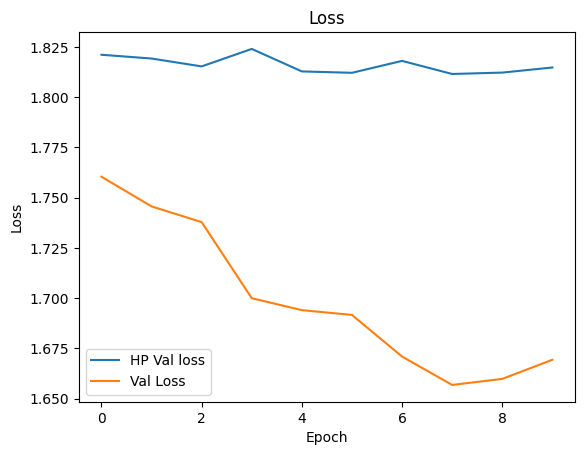

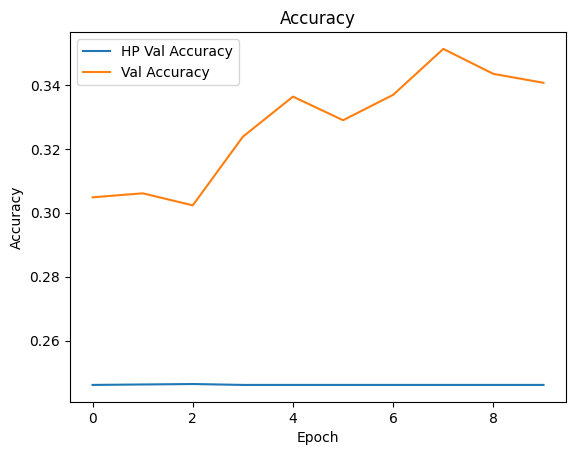

In [26]:
# Tracer la courbe de perte
plt.plot(val_loss_history_hp, label='HP Val loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Tracer la courbe d'accuracy
plt.plot(val_acc_history_hp, label='HP Val Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
